This is a stripped down version of the tutorial notebook available here:
https://github.com/junaidaliop/pytorch-fashionMNIST-tutorial/blob/main/pytorch_fashion_mnist_tutorial.ipynb

The major changes I made was to increase the batch size for the training data, and to also add a sequential style neural network.

**IMPORTANT** To make sure you are running the algorithm quickly, ensure you are using a runtime with a GPU.  To access this, click on the "Runtime" menu at the top of the page and select "Change Runtime".  Then make sure you pick one of the available (free) GPU options

In [2]:
# PyTorch Tutorial: Fashion MNIST with Convolutional Neural Networks (CNNs)

# Welcome to this hands-on tutorial on deep learning with PyTorch using the Fashion MNIST dataset.
# This notebook will guide you through the process of building a Convolutional Neural Network (CNN) to classify fashion items.

# Setup and Installation

# Importing essential libraries and modules for deep learning and visualization
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Setting up device for GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

device


Running on cuda.


device(type='cuda')

**Important:** The above output should read:

```
Running on cuda.
device(type='cuda')
```

If it does not, make sure you've selected a runtime with a GPU.


In [33]:
# Import the necessary transformations module from torchvision
import torchvision.transforms as transforms

# Define a transformation pipeline.
# Here, we're only converting the images to PyTorch tensor format.
transform = transforms.Compose([transforms.ToTensor()])

# Using torchvision, load the Fashion MNIST training dataset.
# root specifies the directory where the dataset will be stored.
# train=True indicates that we want the training dataset.
# download=True will download the dataset if it's not present in the specified root directory.
# transform applies the defined transformations to the images.
trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

# Create a data loader for the training set.
# It will provide batches of data, in this case, batches of size 4.
# shuffle=True ensures that the data is shuffled at the start of each epoch.
# num_workers=2 indicates that two subprocesses will be used for data loading.
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128, # In the original note book, the batch size was set to 4, it makes for a very slow model.
    shuffle=True,
    num_workers=2,
)

# Similarly, load the Fashion MNIST test dataset.
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
)

# Define the class labels for the Fashion MNIST dataset.
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Input: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(1, 32, 3)  # Output: [batch_size, 32, 26, 26]

        # Input: [batch_size, 32, 26, 26]
        self.conv2 = nn.Conv2d(32, 64, 3) # Output: [batch_size, 64, 11, 11]

        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Flattening: [batch_size, 64*5*5]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # Shape: [batch_size, 32, 26, 26]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 32, 13, 13]

        x = F.relu(self.conv2(x))
        # Shape: [batch_size, 64, 11, 11]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 64, 5, 5]

        x = x.view(-1, 64 * 5 * 5) # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [13]:
model = BasicCNN().to(device)

In [35]:
model = nn.Sequential(
    nn.Conv2d(1,32,3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # nn.Conv2d(32,64,3), # Comment these three lines in to get the BasicCNN model
    # nn.ReLU(),
    # nn.MaxPool2d(2),
    nn.Flatten(),
    # nn.Linear(64 * 5 * 5, 128) #comment these two lines in to get BasicCNN model
    # nn.Linear(128, 10)
    nn.Linear(32*13*13,10) # Comment this line out to get BasicCNN model.
).to(device)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
# Number of complete passes through the dataset
num_epochs = 5

# Start the training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Iterate over each batch of the training data
    for images, labels in trainloader:
        # Move the images and labels to the computational device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Clear the gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: Pass the images through the model to get the predicted outputs
        outputs = model(images)

        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: Compute the gradient of the loss w.r.t. model parameters
        loss.backward()

        # Update the model parameters
        optimizer.step()


              precision    recall  f1-score   support

 T-shirt/top       0.81      0.89      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.79      0.88      0.83      1000
       Dress       0.88      0.93      0.90      1000
        Coat       0.86      0.82      0.84      1000
      Sandal       0.96      0.99      0.97      1000
       Shirt       0.79      0.61      0.69      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



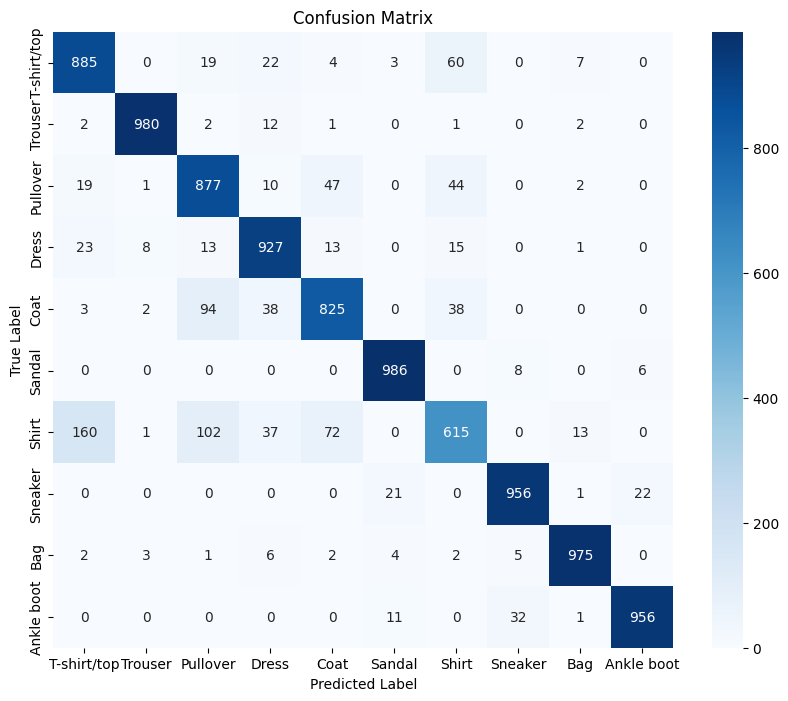

In [32]:
# Import necessary libraries:
# numpy for numerical operations
# sklearn.metrics for evaluation metrics like classification report and confusion matrix
# seaborn and matplotlib for data visualization
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode. This is important as certain layers like dropout behave differently during training and evaluation.
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# We don't want to compute gradients during evaluation, hence wrap the code inside torch.no_grad()
with torch.no_grad():
    # Iterate over all batches in the test loader
    for images, labels in testloader:
        # Transfer images and labels to the computational device (either CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Pass the images through the model to get predictions
        outputs = model(images)

        # Get the class with the maximum probability as the predicted class
        _, predicted = torch.max(outputs, 1)

        # Extend the all_preds list with predictions from this batch
        all_preds.extend(predicted.cpu().numpy())

        # Extend the all_labels list with true labels from this batch
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model's performance for each class
print(classification_report(all_labels, all_preds, target_names=classes))

# Compute the confusion matrix using true labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot
